In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams['figure.dpi']=200
plt.rcParams['font.size']=16
plt.rcParams['legend.fontsize']='small'
plt.rcParams['xtick.labelsize']='small'
plt.rcParams['ytick.labelsize']='small'
plt.rcParams['mathtext.fontset']='cm'

In [3]:
# Download Tables
import urllib.request
import os

if not os.path.isfile('./table-mean.ecsv'):
    urllib.request.urlretrieve('https://changgoo.github.io/tigress-wind-figureset/tables/table-mean.ecsv',
                              'table-mean.ecsv')
if not os.path.isfile('./table-mean-err.ecsv'):
    urllib.request.urlretrieve('https://changgoo.github.io/tigress-wind-figureset/tables/table-mean-err.ecsv',
                              'table-mean-err.ecsv')
if not os.path.isfile('./table-std.ecsv'):
    urllib.request.urlretrieve('https://changgoo.github.io/tigress-wind-figureset/tables/table-std.ecsv',
                              'table-std.ecsv')

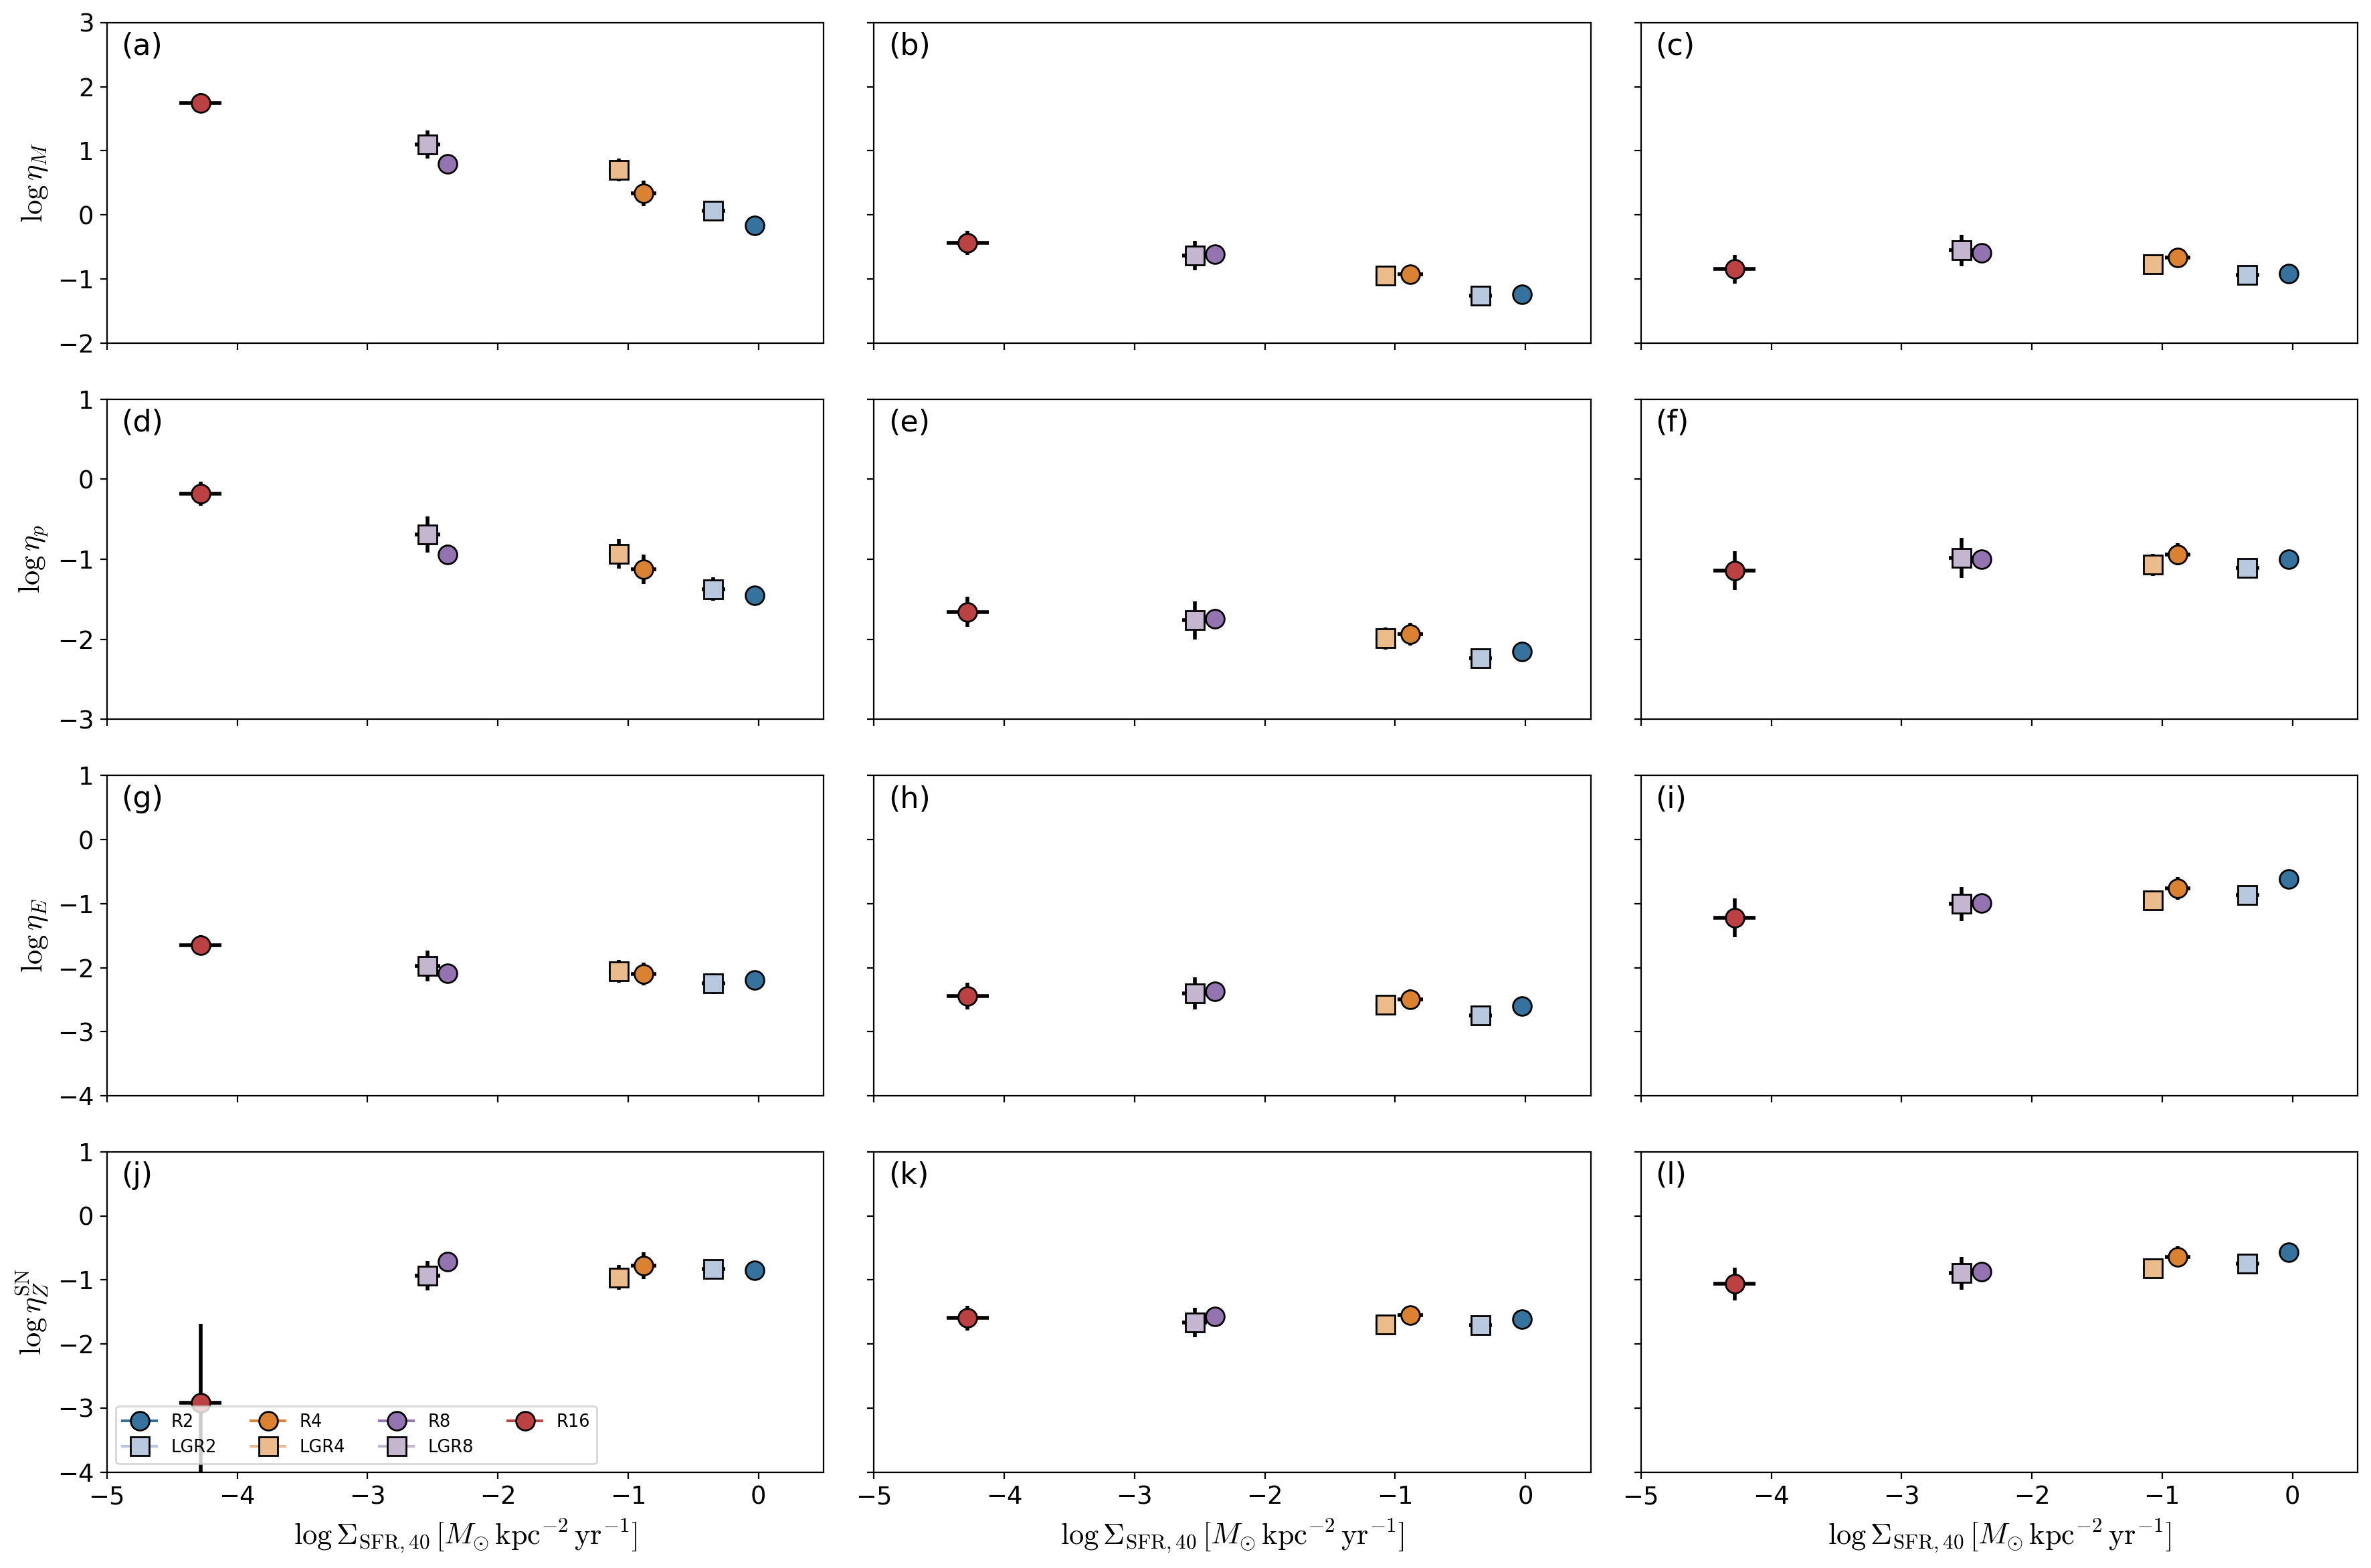

In [4]:
import seaborn as sns
# Read Tables with astropy:

from astropy.table import QTable,Table
tmean=Table.read('./table-mean.ecsv')
tstd=Table.read('./table-mean-err.ecsv')

# Reproduce Figure 6 including (intermediate phase):
colors=sns.color_palette('tab20',n_colors=20,desat=0.7)
colors=colors[:2]+colors[2:4]+colors[8:10]+colors[6:8]

markers=['o', 's', 'o', 's', 'o', 's', 'o']
names=['R2', 'LGR2', 'R4', 'LGR4', 'R8', 'LGR8', 'R16']

yfields=['mass_loading','mom_loading','energy_loading','metal_sn_loading']
labels=[r'$\eta_M$',r'$\eta_p$',r'$\eta_E$',r'$\eta_Z^{\rm SN}$']
phases=['cool','int','hot']

Nrows=len(yfields)
Ncols=len(phases)
z = 'H'
xfield = 'sfr40'
xlabel=r'$\Sigma_{{\rm SFR,40}}\,[M_{\odot}{\rm \, kpc^{-2}\,yr^{-1}}]$'

fig, axes = plt.subplots(Nrows,Ncols,figsize=(6*Ncols,3*Nrows),
                         sharex='col',sharey='row',squeeze=False)

for i,field in enumerate(yfields):
    for j,ph in enumerate(phases):
        plt.sca(axes[i,j])
        for name,c,m in zip(names,colors,markers):
            idx=(tmean['phase'] == ph) & (tmean['z'] == z) & (tmean['model'] == name)
            xmean = tmean[idx][xfield]
            ymean = tmean[idx][field]
            xstd = tstd[idx][xfield]
            ystd = tstd[idx][field]
            xlogstd= xstd/xmean/np.log(10)
            ylogstd= ystd/ymean/np.log(10)
            plt.errorbar(np.log10(xmean),np.log10(ymean),
                         xerr=xlogstd,yerr=ylogstd,
                         color=c,marker=m,label=name,
                         elinewidth=2,ecolor='k',markersize=10.0,
                         markeredgecolor='k',markeredgewidth=1,
                        )
        
# Decorating axes
axes[-1,0].legend(fontsize='xx-small',ncol=4,loc='lower left')
plt.setp(axes,'xlim',(-5,0.5))
axes[0,0].set_ylim(-2,3)
axes[1,0].set_ylim(-3,1)
axes[2,0].set_ylim(-4,1)
axes[3,0].set_ylim(-4,1)
for ax,lab in zip(axes.flat,'abcdefghijklmnopqrstuvwxyz'):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.annotate('({})'.format(lab),[0.02,0.90],xycoords='axes fraction')

for ax,lab in zip(axes[:,0],labels):
    ax.set_ylabel(r'$\log\,$'+lab)
plt.setp(axes[-1,:],'xlabel',r'$\log\,$'+xlabel)
plt.tight_layout()

In [5]:
# re-fitting with linmix
# note that the refitting will not give the identical posterior distributions 
# reported in the paper (Table 5), but should be consistent
import linmix

ph='cool'
z='H'
xfield='sfr40'
yfield='mass_loading'

# selecting phase, height, xfield, and yfield from the table
# and construct arrays for 7 models
idx=(tmean['phase'] == ph) & (tmean['z'] == z)
xmean = tmean[idx][xfield]
ymean = tmean[idx][yfield]
xstd = tstd[idx][xfield]
ystd = tstd[idx][yfield]
xlog=np.log10(xmean)
ylog=np.log10(ymean)
xlogstd= xstd/xmean/np.log(10)
ylogstd= ystd/ymean/np.log(10)

In [6]:
# run MCMC
lm=linmix.LinMix(xlog,ylog,xsig=xlogstd,ysig=ylogstd)
lm.run_mcmc(silent=True)

In [7]:
def plot_posterior_hist(axes,chain,mean=True,interval=True,autorange=True,color='C0',**kwargs):

    fields=['alpha','beta','sigsqr','corr']
    for field,ax in zip(fields,axes.flat):
        plt.sca(ax)
        q=np.quantile(chain[field],[0.025,0.16,0.5,0.84,0.975])
        plt.hist(chain[field],bins=np.linspace(q[0],q[4],50),alpha=0.5,color=color,**kwargs);
        if mean: plt.axvline(q[2],color=color)
        if interval:
            plt.axvline(q[1],ls=':',color=color)
            plt.axvline(q[3],ls=':',color=color)
        plt.xlabel(field)
        if autorange: plt.xlim(q[0],q[4])

In [8]:
import corner

Text(0.95, 0.9, 'Cov$(\\alpha, \\beta)=+0.017$')

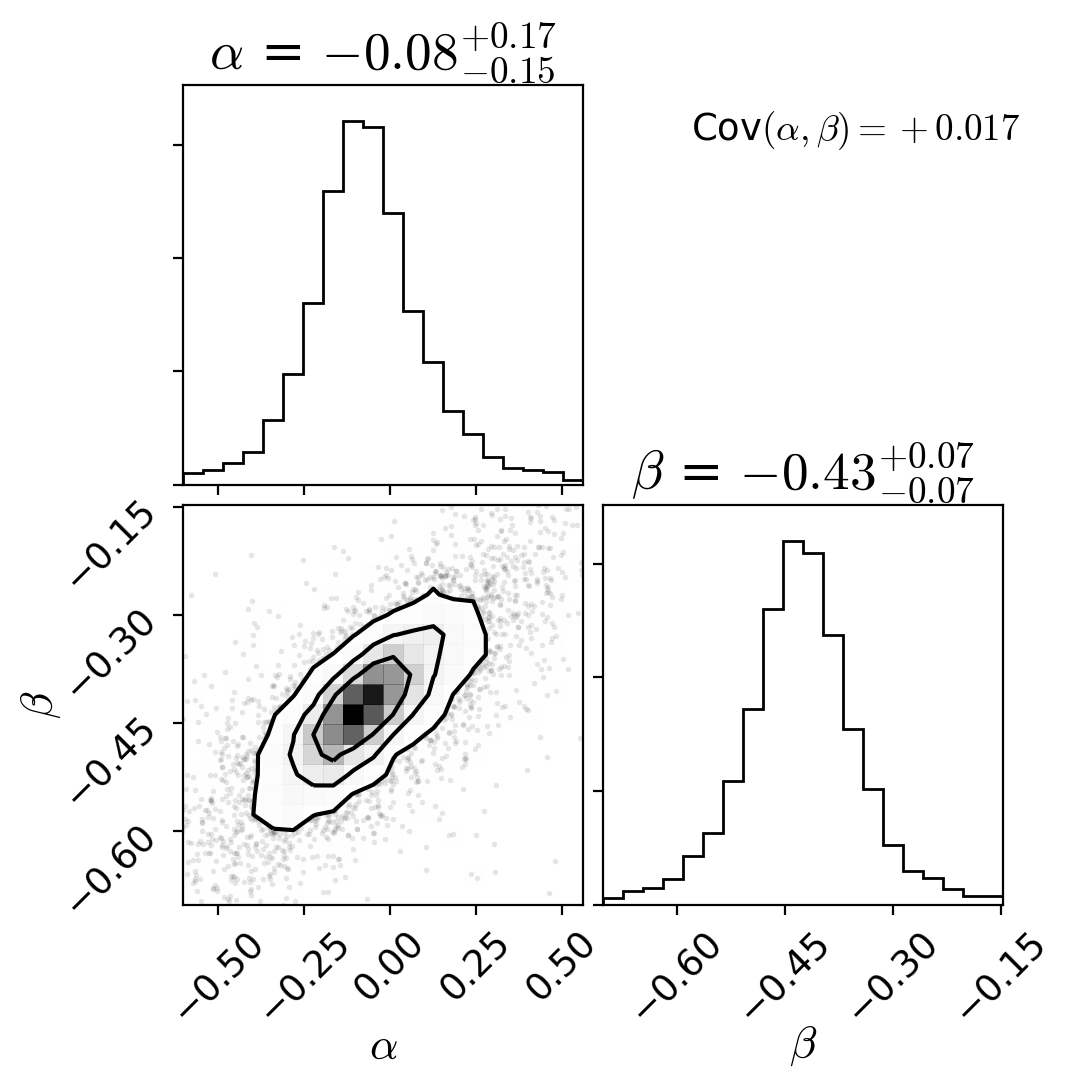

In [9]:
chain=lm.chain
cov=np.cov(chain['alpha'],chain['beta'])[1,0]
r1=np.quantile(chain['alpha'],[0.01,0.99])
r2=np.quantile(chain['beta'],[0.01,0.99])
f=corner.corner(np.array([chain['alpha'],chain['beta']]).T,range=[r1,r2],
                show_titles=True,labels=[r'$\alpha$',r'$\beta$'],)
plt.annotate('Cov'+r'$(\alpha, \beta)={:+.3f}$'.format(cov),
             (0.95,0.9),xycoords='figure fraction',ha='right',va='top',fontsize='small')

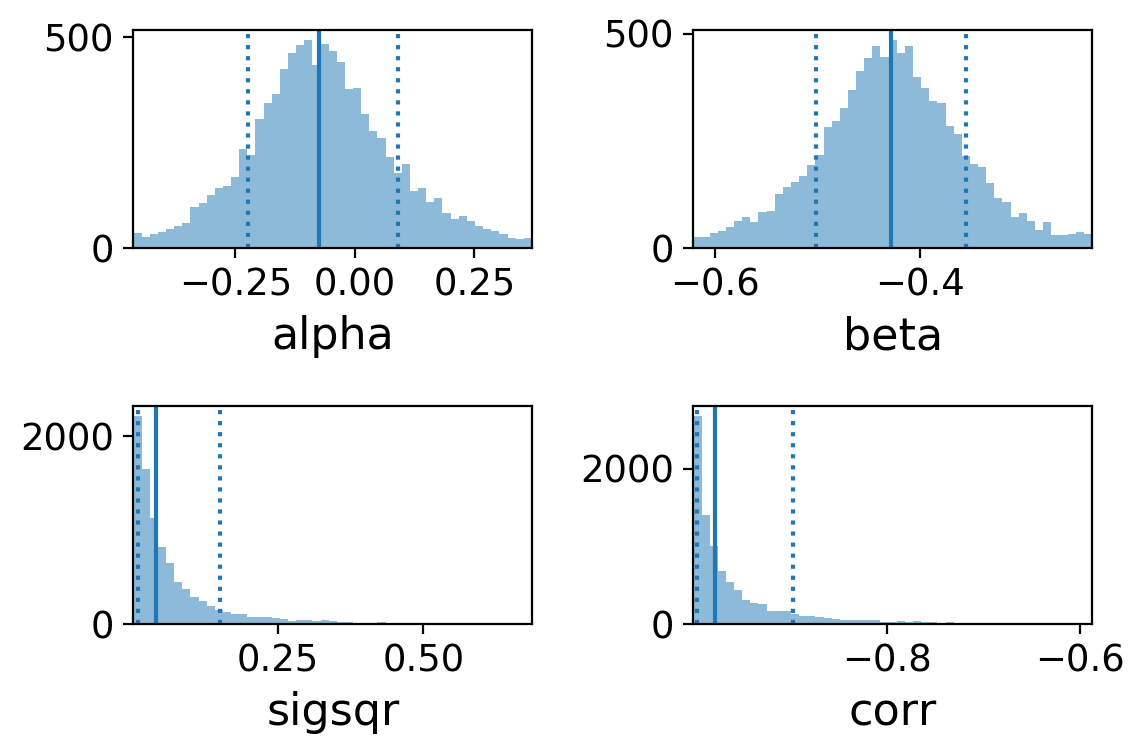

In [10]:
# plot historams of posterior distributions
fig,axes=plt.subplots(2,2)
plot_posterior_hist(axes,lm.chain)
plt.tight_layout()

In [14]:
def result_string(chain,sep='\n',table=False):
    result_str=[]
    for field,name in zip(['alpha','beta','sigsqr','corr'],
                          [r'\alpha',r'\beta',r'\sigma_{\rm int}',r'\rho']):
        q=np.quantile(chain[field],[0.16,0.5,0.84])
        if table:
            if field is 'sigsqr':
                q=np.quantile(np.sqrt(chain[field]),[0.68,0.95])
                result_str.append('{:.2f}'.format(q[0]))
            else:
                result_str.append(display_quantiles(q))
        else:
            if field is 'sigsqr':
                q=np.quantile(np.sqrt(chain[field]),[0.68,0.95])
                result_str.append(r'${}='.format(name)+'{:.2f}'.format(q[0])+'$')
            else:
                result_str.append(r'${}='.format(name)+display_quantiles(q)+'$')
        result_str.append(sep)
    return ' '.join(result_str[:-1])

def display_quantiles(q):
    med=q[1]
    upper=q[2]-q[1]
    lower=q[1]-q[0]
    fmt_str = '{val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}'
    disp_str = fmt_str.format(val=med, plus=upper, minus=lower)
    return disp_str

In [12]:
def plot_mcmc_result(chain,xmin,xmax,color='k',
                     intrinsic_scatter=True,result_str=True,
                     interval=True,median=True,**kwargs):
    xs=np.linspace(xmin,xmax,100)
    a=chain['alpha']
    b=chain['beta']
    e=np.sqrt(chain['sigsqr'])
    eps1=np.quantile(np.sqrt(chain['sigsqr']),0.68)
    eps2=np.quantile(np.sqrt(chain['sigsqr']),0.95)
    eps=np.quantile(np.sqrt(chain['sigsqr']),0.5)
    if intrinsic_scatter:
        ys=np.concatenate([(a+xs[:,np.newaxis]*b-e),(a+xs[:,np.newaxis]*b+e)],axis=-1)
    else:
        ys=a+xs[:,np.newaxis]*b
    y2s_lower,y1s_lower,pme,y1s_upper,y2s_upper = np.quantile(ys,[0.025,0.16,0.5,0.84,0.975],axis=-1)

    if median: plt.plot(xs,pme,color=color,**kwargs)
    else: plt.plot(xs,ys.mean(axis=-1),color=color,**kwargs)

    if interval:
        plt.fill_between(xs,y1s_lower,y1s_upper,alpha=0.1,color=color)
        plt.fill_between(xs,y2s_lower,y2s_upper,alpha=0.1,color=color)

    if type(result_str) == bool:
        if result_str: plt.annotate(result_string(chain),[0.05,0.05],fontsize='x-small',xycoords='axes fraction')
    else:
        from matplotlib.offsetbox import AnchoredText
        at = AnchoredText(result_string(chain),
                          prop=dict(size='x-small'),
                          loc=result_str,frameon=True)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        at.patch.set_alpha(0.5)
        at.patch.set_facecolor('#FFFACD')
        at.patch.set_linewidth(0)
        plt.gca().add_artist(at)

(-5, 0.5)

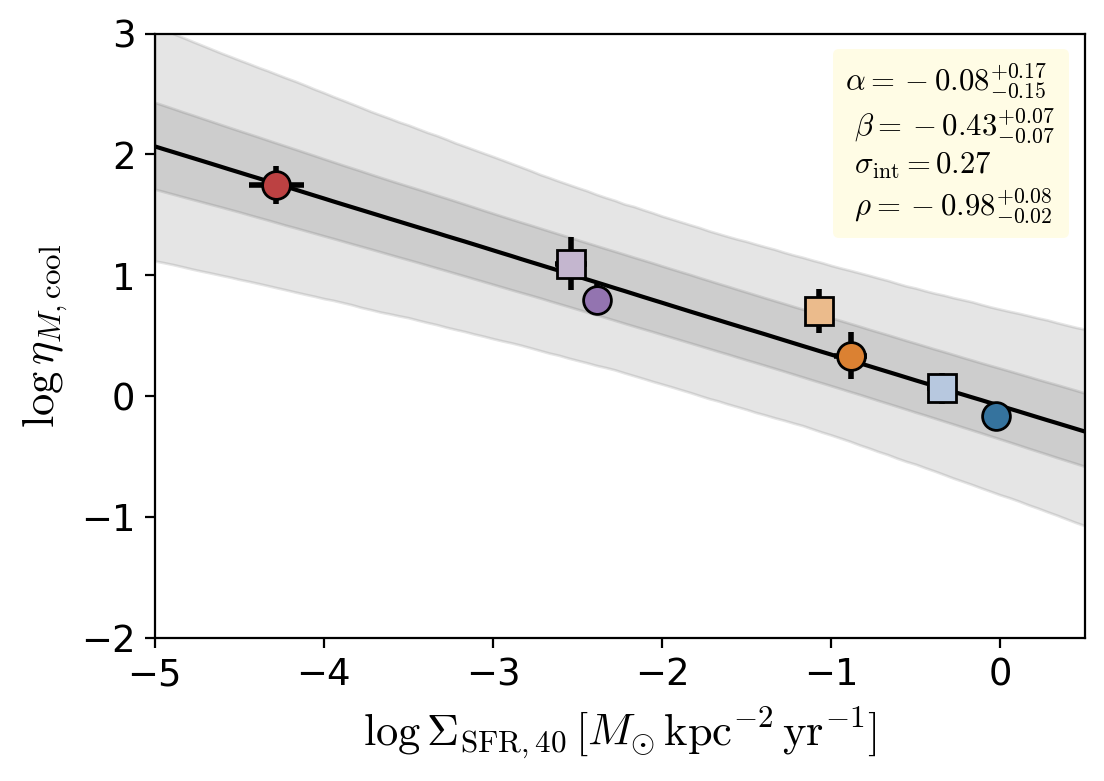

In [15]:
# plot MCMC results as in the paper

for name,c,m in zip(names,colors,markers):
    idx=(tmean['phase'] == ph) & (tmean['z'] == z) & (tmean['model'] == name)
    xmean = tmean[idx][xfield]
    ymean = tmean[idx][yfield]
    xstd = tstd[idx][xfield]
    ystd = tstd[idx][yfield]
    xlogstd= xstd/xmean/np.log(10)
    ylogstd= ystd/ymean/np.log(10)
    plt.errorbar(np.log10(xmean),np.log10(ymean),
                 xerr=xlogstd,yerr=ylogstd,
                 color=c,marker=m,label=name,
                 elinewidth=2,ecolor='k',markersize=10.0,
                 markeredgecolor='k',markeredgewidth=1,
                )

plot_mcmc_result(lm.chain,-5,0.5,result_str=1,)
plt.ylabel(r'$\log\,\eta_{M, {\rm cool}}$')
plt.xlabel(r'$\log\,$'+xlabel)
plt.ylim(-2,3)
plt.xlim(-5,0.5)